|# Atividade 4 - Processamento de Imagens - CHT

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import coins
from skimage.io import imread
from skimage.filters import sobel
from skimage.morphology import binary_opening, binary_closing
from skimage import color
from skimage.draw import circle_perimeter
from skimage.transform import resize

## Função para calcular os acumuladores da CHT

In [ ]:
def hough_circle(edges, raios):

    H, W = edges.shape # altura e largura da imagem de bordas 
    num_raios = len(raios)
    # acumulador
    acc = np.zeros((num_raios, H, W), dtype=np.uint64)
    
    # P/ cada raio
    # ? REVER PQ TÁ SAINDO AASSIM??? 
    for r_idx, r in enumerate(raios):
        # gera pontos do perímetro do círculo para raio r
        num_pontos = max(int(2 * np.pi * r), 1)
        theta = np.linspace(0, 2 * np.pi, num_pontos)
        
        # formula paramétrica do círculo:
        # dx = r * cos(theta)
        # dy = r * sin(theta)
        dx = np.round(r * np.cos(theta)).astype(int)
        dy = np.round(r * np.sin(theta)).astype(int)
        points = np.column_stack((dx, dy))
        unique_points = np.unique(points, axis=0)
        
        # obtém coordenadas das bordas
        y_edges, x_edges = np.nonzero(edges)
        
        # p/ cada ponto único
        for dx, dy in unique_points:
            # mapeando os pontos de borda para os respectivos centros:
            # a = x_borda - dx
            # b = y_borda - dy
            a = x_edges - dx
            b = y_edges - dy
            
            # filtra coordenadas válidas
            valid = (a >= 0) & (a < W) & (b >= 0) & (b < H)
            a_valid = a[valid]
            b_valid = b[valid]
            
            # atualiza o acumulador p/ o raio atual
            np.add.at(acc[r_idx], (b_valid, a_valid), 1)
    
    return acc # retorna o acumulador 

## Função para os picos da CHT

In [27]:
def hough_circle_peaks(hough_space, min_distance=10, total_num_peaks=1):
    
    picos = []
    H, W = hough_space.shape
    
    # coleta e ordena por votos
    flat_acc = hough_space.ravel()
    sorted_indices = np.argsort(flat_acc)[::-1]
    
    # converte índices para coordenadas
    b_indices, a_indices = np.unravel_index(sorted_indices, hough_space.shape)
    
    detectados = []
    acc = []
    a_coord = []
    b_coord = []

    # p/ cada índice ordenado
    for idx in range(len(sorted_indices)):
        a = a_indices[idx]
        b = b_indices[idx]
        votos = flat_acc[sorted_indices[idx]]
        
        if votos == 0:
            continue
        
        # verifica distância mínima
        valido = True
        for (sel_a, sel_b) in detectados:
            distance = np.sqrt((sel_a - a)**2 + (sel_b - b)**2)
            if distance < min_distance:
                valido = False
                break
        if valido:
            detectados.append((a, b))
            acc.append(votos)
            a_coord.append(a)
            b_coord.append(b)
            if len(detectados) >= total_num_peaks:
                break
    
    return acc, a_coord, b_coord

## Imagem Utilizada

Text(0.5, 1.0, 'Img original em grayscale')

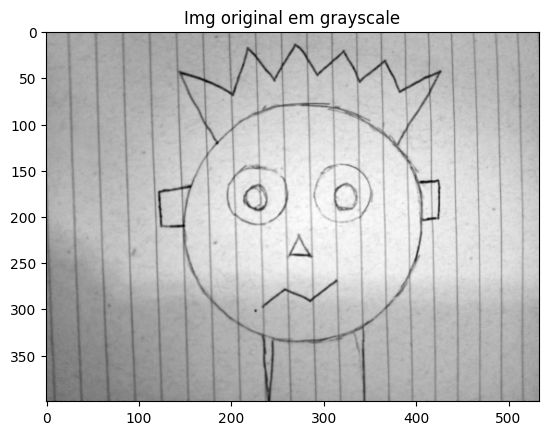

In [28]:
image = imread('desenho3.jpg')
if image.shape[-1] == 4:
    image = image[..., :3]
image = color.rgb2gray(image)
image = resize(image, (image.shape[0] // 3, image.shape[1] // 3), anti_aliasing=True)

plt.imshow(image, cmap='gray')
plt.title('Img original em grayscale')


## Detecção de bordas utilizando a ferramenta Sobel

Text(0.5, 1.0, 'Sobel')

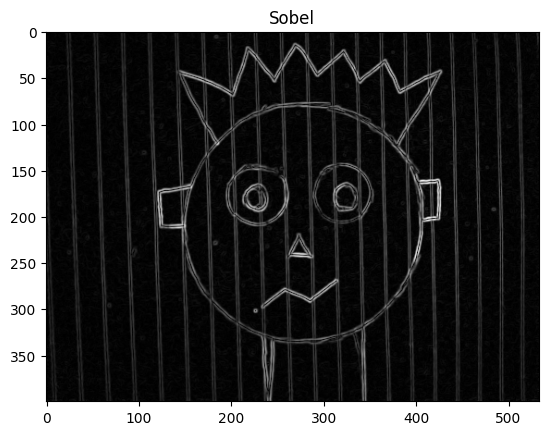

In [29]:
edges = sobel(image)
plt.imshow(edges, cmap='gray')
plt.title('Sobel')

## Histograma das Bordas

Text(0.5, 1.0, 'histograma das bordas')

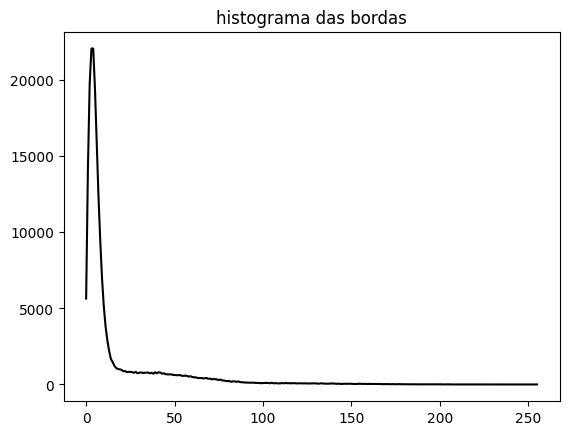

In [30]:
h = np.histogram(edges.ravel(), bins=256)
plt.plot(h[0], '-k')
plt.title('histograma das bordas')

## Imagem Binária

Text(0.5, 1.0, 'Img binária')

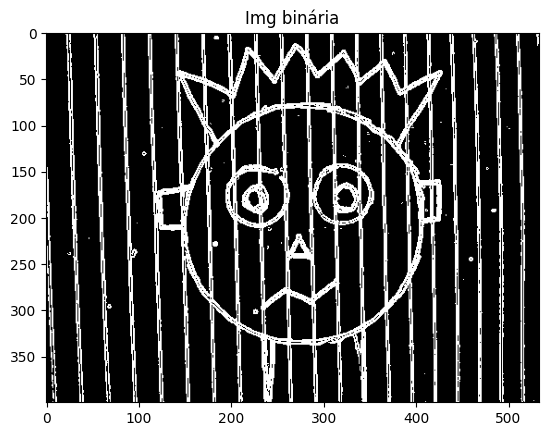

In [31]:
binary = edges.copy()
limiar = image.max() * (10/256)
binary[binary <= limiar] = 0
binary[binary > limiar] = 1
plt.imshow(binary * 255, cmap='gray')
plt.title('Img binária')

## Imagem após abertura e fechamento

Text(0.5, 1.0, 'Img após abertura e fechamento')

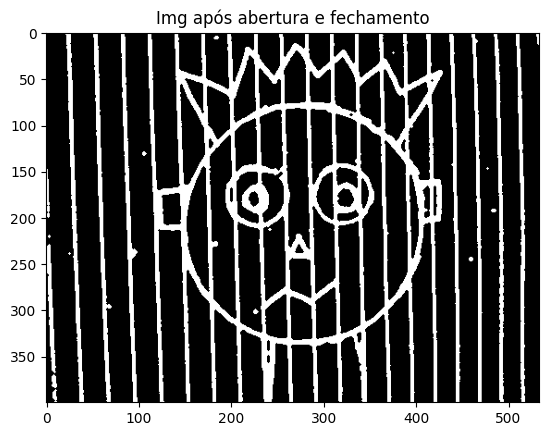

In [32]:
binary = binary_closing(binary)
binary = binary_opening(binary)
plt.imshow(binary, cmap='gray')
plt.title('Img após abertura e fechamento')

## Aplicando CHT

In [33]:
# aplicando CHT
raios = [13, 30, 130]
hough_grade = hough_circle(binary, raios)

### Raio 13

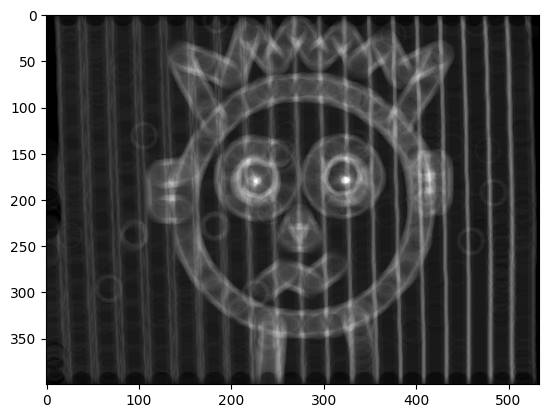

In [34]:
grade = hough_grade[0] # raio = 13
plt.imshow (grade,cmap='gray')

### Raio 30

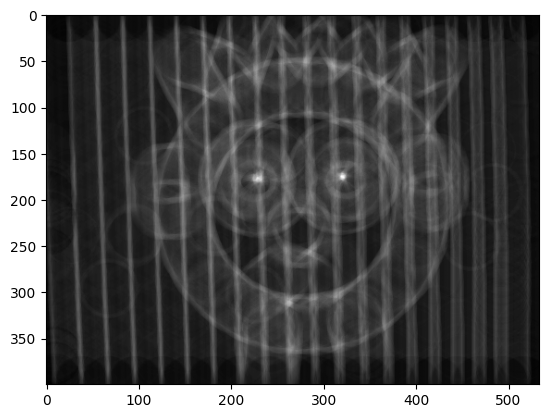

In [35]:
grade = hough_grade[1] # raio = 30
plt.imshow (grade,cmap='gray')

### Raio 130

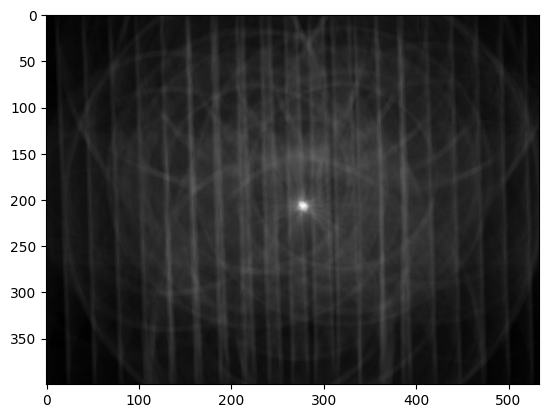

In [36]:
grade = hough_grade[2] # raio = 130
plt.imshow (grade,cmap='gray')

## Desenhando os círculos detectados
Obs.: Por necessidade foi necessário aplicar um filtro da quantidade de picos por raio, pois o mesmo estava dando prioridade ao raio de maior valor pela quantidade de votos.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..220.0].


Text(0.5, 1.0, 'Círculos detectados')

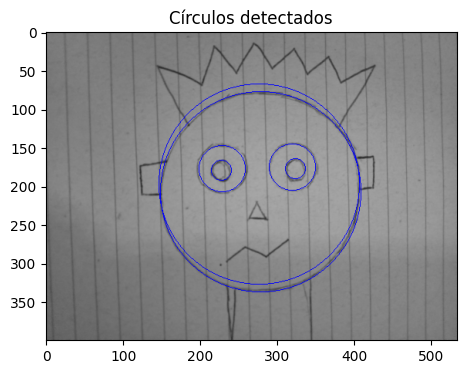

In [37]:
# filtrar os picos p aparecerem todos os raios
# ! REVER, samerda táa excedendo os vaalores
n_picos_por_raio = 2 
picos_filtrados = []

for r_idx, r in enumerate(raios):
    acc_raio = hough_grade[r_idx]
    acumuladores, a, b = hough_circle_peaks(acc_raio, min_distance=10, total_num_peaks=n_picos_por_raio)
    for a_val, b_val in zip(a, b):
        picos_filtrados.append((a_val, b_val, r))

# ter q separar as listas filtradas
a_filtrado = [p[0] for p in picos_filtrados]
b_filtrado = [p[1] for p in picos_filtrados]
detected_raios_filtrado = [p[2] for p in picos_filtrados]

# desenha os círculos detectados
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image_color = color.gray2rgb(image)
for center_x, center_y, radius in zip(a_filtrado, b_filtrado, detected_raios_filtrado):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image_color[circy, circx] = (0, 0, 220) 

ax.imshow(image_color, cmap=plt.cm.gray)
plt.title('Círculos detectados')